In [22]:
import pandas as pd
import numpy as np
import os, random
from sklearn.metrics import classification_report
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2 as cv
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [2]:
label_class = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
class_label = {v: k for k, v in label_class.items()}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_base_path = 'images/train/'
val_base_path = 'images/validation/'

classes = list(label_class.values())
train_paths = [train_base_path + each_class for each_class in classes]
val_paths = [val_base_path + each_class for each_class in classes]

In [4]:
def load_data(addr, classes_dict):
        
    imgs = []
    
    for paths in addr:
        mood_class = paths.split('/')[-1]
        samples = os.listdir(paths)
        for i, each_sample in enumerate(samples):
            imgs.append((cv.cvtColor(cv.imread(paths + '/' + each_sample), cv.COLOR_BGR2GRAY), classes_dict[mood_class]))

    random.shuffle(imgs)
            
    return np.array([each[0] for each in imgs]), np.array([each[1] for each in imgs])

In [5]:
tr_data, tr_lbls = load_data(train_paths, class_label)
val_data, val_lbls = load_data(val_paths, class_label)

In [6]:
tr_data.shape

(28821, 48, 48)

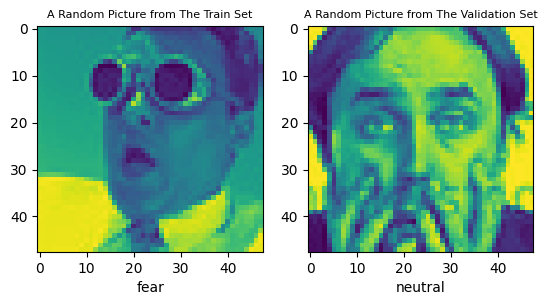

In [7]:
tr_idx = random.randint(0, tr_data.shape[0])
val_idx = random.randint(0, val_data.shape[0])
img1 = tr_data[tr_idx]
lbl1 = tr_lbls[tr_idx]
img2 = val_data[val_idx]
lbl2 = val_lbls[val_idx]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel(label_class[lbl1])
ax1.set_title('A Random Picture from The Train Set', fontsize=8)
ax2.set_xlabel(label_class[lbl2])
ax2.set_title('A Random Picture from The Validation Set', fontsize=8)

ax1.imshow(img1)
ax2.imshow(img2)

In [8]:
tr_tensor = torch.from_numpy(tr_data) / 255
val_tensor = torch.from_numpy(val_data) / 255
tr_lbl_tensor = torch.from_numpy(tr_lbls).long()
val_lbl_tensor = torch.from_numpy(val_lbls).long()

In [9]:
tr_lbl_tensor.shape

torch.Size([28821])

In [10]:
m, w, h = tr_tensor.shape 
tr_tensor = tr_tensor.reshape((m, 1, w, h))

m, w, h = val_tensor.shape 
val_tensor = val_tensor.reshape((m, 1, w, h))

In [11]:
tr_tensor.shape

torch.Size([28821, 1, 48, 48])

In [12]:
val_tensor.shape

torch.Size([7066, 1, 48, 48])

In [13]:
BATCH_SIZE = 64

In [14]:
tr_loader = DataLoader(list(zip(tr_tensor, tr_lbl_tensor)), shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(list(zip(val_tensor, val_lbl_tensor)), shuffle=True, batch_size=BATCH_SIZE)

In [85]:
class Model(nn.Module):
    def __init__(self, num_features):
        
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(num_features, 128, 3, padding='same')
        self.batch1 = nn.BatchNorm2d(128)
        self.drp1 = nn.Dropout2d(0.1)
        
        self.conv2 = nn.Conv2d(128, 256, 3, padding='same')
        self.batch2 = nn.BatchNorm2d(256)
        self.drp2 = nn.Dropout2d(0.1)

        self.conv3 = nn.Conv2d(256, 512, 3, padding='same')
        self.batch3 = nn.BatchNorm2d(512)
        self.drp3 = nn.Dropout2d(0.1)
        
        
        self.fc1 = nn.Linear(512 * 6 * 6, 256, True)
        self.batch5 = nn.BatchNorm1d(256)
        self.drp4 = nn.Dropout1d(0.1)
        
        self.fc2 = nn.Linear(256, 128, True)
        self.batch6 = nn.BatchNorm1d(128)
        self.drp5 = nn.Dropout1d(0.1)

        self.fc3 = nn.Linear(128, 64, True)
        self.batch7 = nn.BatchNorm1d(64)
        self.drp6 = nn.Dropout1d(0.1)
        
        self.fc4 = nn.Linear(64, 7, True)
        # self.act2 = nn.Softmax(dim=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        # self.act1 = nn.functional.relu()
        self.flat = nn.Flatten()


    
    def forward(self, x):

        # print(x.shape)
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = self.pool(x)
        x = self.drp1(x)
        # print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.batch2(x)
        x = self.pool(x)
        x = self.drp2(x)
        # print(x.shape)
        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        x = self.pool(x)
        x = self.drp3(x)
        # x = self.drp3(self.pool(self.batch3(self.conv3(x))))
        # print(x.shape)
        # x = self.pool(self.batch4(self.conv4(x)))
        # print(x.shape)

        x = self.flat(x)
        
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.batch5(x)
        x = self.drp4(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.batch6(x)
        x = self.drp5(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        x = self.batch7(x)
        x = self.drp6(x)
        
        # x = self.act1(self.batch7(self.fc3(x)))
        x = self.fc4(x)

        return x

In [86]:
model = Model(1).to(device)

opt = optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

EPOCH = 20
tr_history, val_history = [], []
tr_acc_history, val_acc_history = [], []
correct = 0

In [87]:
for e in range(EPOCH):
    total_loss = 0.0
    correct = 0
    model.train()
    for imgs, lbls in tr_loader:

        imgs = imgs.to(device)
        lbls = lbls.to(device)
        
        opt.zero_grad()
        logits = model(imgs)
        # print('Logit\'s Shape:', logits.shape)
        batch_loss = criterion(logits, lbls)
        # print('Predicted:', predicted)
        batch_loss.backward()
        opt.step()
        
        total_loss += (batch_loss.item())
        # print((predicted == lbls).sum().item())
        _, predicted = torch.max(logits, 1)
        correct += ((predicted == lbls).sum().item()) / (BATCH_SIZE / 100)


    total_loss /= len(tr_loader)
    correct /= len(tr_loader)
    # print('Total Loss:', total_loss)
    # print('Correct:', correct)
    # print('Len of tr Loader:', len(tr_loader))
    tr_history.append(total_loss)
    tr_acc_history.append(correct)



    val_total_loss = 0.0
    val_correct = 0
    model.eval()
    for imgs, lbls in val_loader:

        imgs = imgs.to(device)
        lbls = lbls.to(device)
            
        # opt.zero_grad()
        logits = model(imgs)
        # print(logits.shape)
        batch_loss = criterion(logits, lbls)
        _, predicted = torch.max(logits, 1)
        # batch_loss.backward()
        # opt.step()
            
        val_total_loss += batch_loss.item()
        val_correct += (predicted == lbls).sum().item() / (BATCH_SIZE / 100)
        # tepoch.set_postfix(loss=total_loss, val_loss=val_total_loss, accuracy=100. * correct, val_accuracy=100. * val_correct)
    

    val_total_loss /= len(val_loader)
    val_correct /= len(val_loader)
    
    val_history.append(val_total_loss)
    val_acc_history.append(val_correct)

        # tepoch.set_postfix(loss=batch_loss, accuracy=100. * accuracy)
    epoch = '0' + str(e + 1) if e < 9 else str(e + 1)
    print('Epoch [{}/{}]        loss: {:.3f}    val_loss: {:.3f}    acc: {:.2f}    vall_acc: {:.2f}'.format(epoch,
                                                                                                            EPOCH,
                                                                                                            total_loss,
                                                                                                            val_total_loss, 
                                                                                                            correct,
                                                                                                            val_correct))

Epoch [01/20]        loss: 1.691    val_loss: 1.447    acc: 32.42    vall_acc: 45.76
Epoch [02/20]        loss: 1.468    val_loss: 1.301    acc: 41.92    vall_acc: 51.79
Epoch [03/20]        loss: 1.370    val_loss: 1.233    acc: 46.09    vall_acc: 54.11
Epoch [04/20]        loss: 1.346    val_loss: 1.163    acc: 47.23    vall_acc: 56.53
Epoch [05/20]        loss: 1.282    val_loss: 1.238    acc: 49.89    vall_acc: 55.05
Epoch [06/20]        loss: 1.219    val_loss: 1.125    acc: 52.18    vall_acc: 57.74
Epoch [07/20]        loss: 1.172    val_loss: 1.159    acc: 54.32    vall_acc: 58.84
Epoch [08/20]        loss: 1.176    val_loss: 1.111    acc: 54.05    vall_acc: 58.43
Epoch [09/20]        loss: 1.237    val_loss: 1.133    acc: 51.77    vall_acc: 57.26
Epoch [10/20]        loss: 1.119    val_loss: 1.113    acc: 56.50    vall_acc: 58.88
Epoch [11/20]        loss: 1.047    val_loss: 1.207    acc: 59.36    vall_acc: 55.12
Epoch [12/20]        loss: 1.014    val_loss: 1.097    acc: 60.16

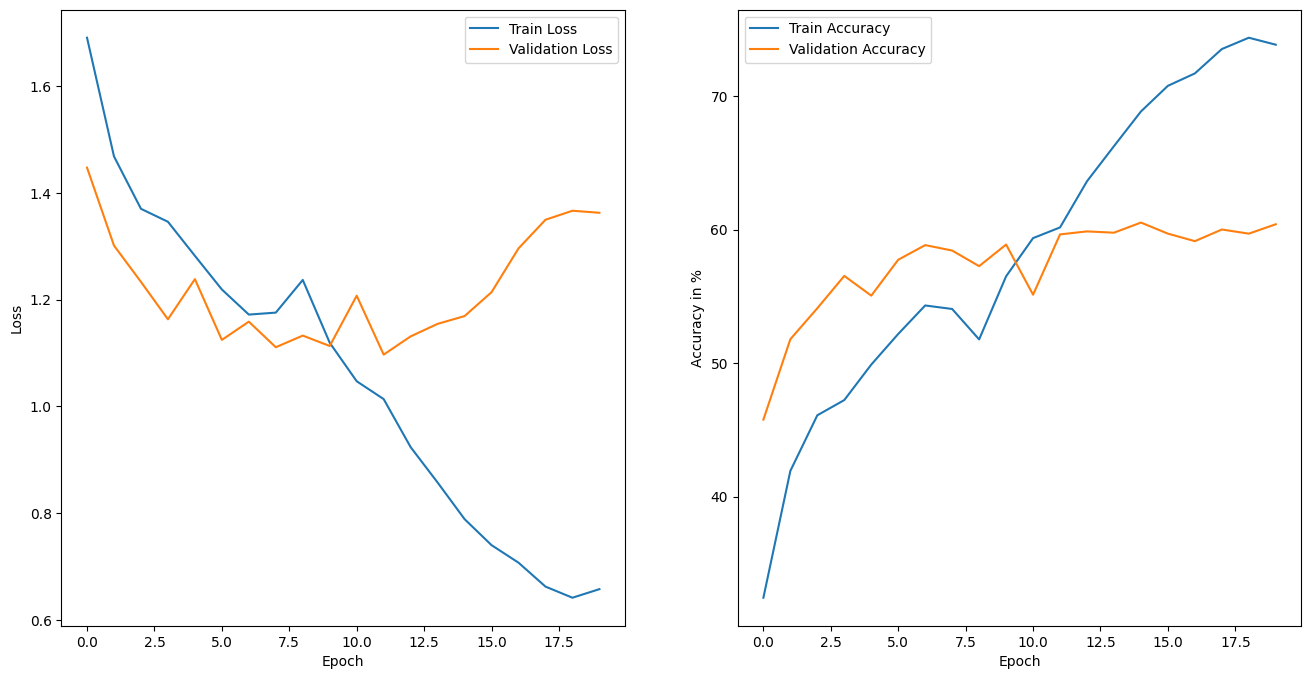

In [88]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(tr_history, label='Train Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(tr_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy in %')
plt.legend()